In [1]:
import numpy as np
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization import QuadraticProgram
from qiskit.primitives import Sampler
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import GurobiOptimizer
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA
import matplotlib.pyplot as plt

In [2]:
# solo hacer una optimizacion

# con escalado
# con estado extra FC-FM
# sin P_M del csv, porque no sabemos el futuro

# parámetros
n_BAT = 1
Ts = 1  # s
C_E = 27000  # kJ
r_FC = 4.7E-8
V_FC = 100
N = 2
P_M = 10

Tend = N

escala = 10000

# sistema espacio estado discreto
# estado x      estado u
# SOC           P_FC
# H2
# P_M
# FC - FM

A = np.array([
    [1, 0, -n_BAT / C_E * Ts * escala, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, -1, 0]
])

B = np.array([
    [n_BAT * Ts / C_E * escala],
    [-r_FC * Ts / V_FC * escala],
    [0],
    [1]
])

n = A.shape[0]  # número de estados
m = B.shape[1]  # número de entradas

# matrices propagación estado
Psi = np.zeros((N * n, n))
for i in range(1, N + 1):
    Psi[n * (i - 1):n * i, :] = np.linalg.matrix_power(A, i)

Upsilon = np.zeros((N * n, m))
for i in range(1, N + 1):
    for j in range(1, i + 1):
        Upsilon[n * (i - 1):n * i, :] += np.linalg.matrix_power(A, j - 1) @ B

Theta = np.zeros((N * n, N * m))
for i in range(1, N + 1):
    for j in range(1, i + 1):
        for k in range(1, i - j + 2):
            Theta[n * (i - 1):n * i, m * (j - 1):m * j] += np.linalg.matrix_power(A, k - 1) @ B

# %% costos
q = np.diag([10, 1, 0, 0])
r = 0
Q = np.kron(np.eye(N), q)
R = np.kron(np.eye(N), r)

# %% referencia
ref = np.array([0.9, 0.9, 0, 0]) * escala
T = np.tile(ref, N)

# %% constraints
# input
u_select = np.array([1])
u_max = 128
u_min = 0
F = np.kron(np.tril(np.ones(N)), np.vstack([u_select, -u_select]))
f = np.tile(np.array([u_max, u_min]), N)

# input rate
du_select = np.array([1])
du_max = 15 * Ts
du_min = 15 * Ts
A_du = np.kron(np.eye(N), np.vstack([du_select, -du_select]))
b_du = np.tile(np.array([du_max, du_min]), N).reshape(-1, 1)

# state
x_select = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
x_max = np.array([1, 1]) * escala
x_min = np.array([0, 0])
Gamma = np.kron(np.eye(N), np.vstack([x_select, -x_select]))
g = np.tile(np.hstack([x_max, x_min]), N)

# %% simular
# condición inicial
x = np.zeros((n, Tend+1))
x[:, 0] = [0.5 * escala, 0.5 * escala, P_M, 0]
u = np.zeros((m, Tend+1))
du = np.zeros((m, Tend+1))

# optimización offline
H = Theta.T @ Q @ Theta + R
H = (H + H.T) / 2

#for k in range(Tend):
k = 0

# optimización online
if k > 0:
    epsilon = T - Psi @ x[:, k] - Upsilon @ u[:, k-1]
else:
    epsilon = T - Psi @ x[:, k]

G = 2 * Theta.T @ Q @ epsilon

# actualizar constraints
A_u = F.copy()
A_x = Gamma @ Theta
if k > 0:
    b_u = -F[:, [0]] @ u[:, [k-1]] + f.reshape(-1, 1)
    b_x = -Gamma @ (Psi @ x[:, [k]] + Upsilon @ u[:, [k-1]]) + g.reshape(-1, 1)
else:
    b_u = f.reshape(-1, 1)
    b_x = -Gamma @ (Psi @ x[:, [k]]) + g.reshape(-1, 1)

Ac = np.vstack([A_du, A_u, A_x])
bc = np.vstack([b_du, b_u, b_x])

In [6]:
# crear problema normal (con enteros)
problem = QuadraticProgram("qp");
problem.integer_var_list(m*N, -30, 30, "du");
problem.minimize(linear=-G.astype(int), quadratic=H.astype(int));
for i in range(bc.size):
    problem.linear_constraint(Ac[i,:].astype(int), '<=', bc[i].astype(int));

In [8]:
# crear problema qubo
conv = QuadraticProgramToQubo()
qubo = conv.convert(problem)
qubo

<QuadraticProgram: minimize 121*c0@int_slack@0^2 + 484*c0@int_slack@0*c0@int_s..., 55 variables, 0 constraints, 'qp'>

Text(0.5, 1.0, 'SOC y H2')

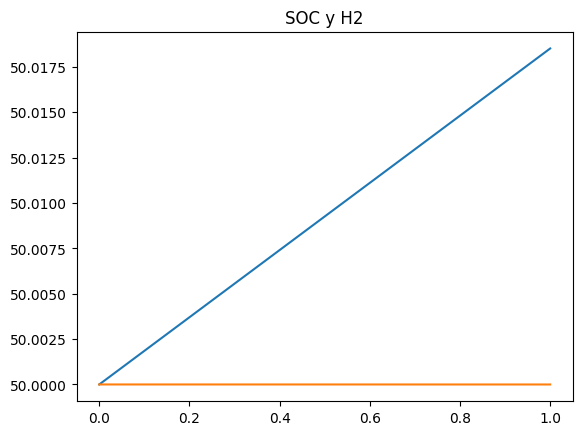

In [7]:
# resolver con gurobi
optimizer = GurobiOptimizer(disp=False)
result = optimizer.solve(problem)

for k in range(Tend):
    du[:,k] = result[k]
    if k > 0:
        u[:,k] = u[:,k-1] + du[:,k]
    else:
        u[:,k] = du[:,k]
    x[:,k+1] = A@x[:,k]+B@u[:,k]
    #x[2,k+1] = P_M[k]

plt.figure()
plt.plot(x[0:2,:].T)
plt.title("SOC y H2")

In [9]:
# https://qiskit-community.github.io/qiskit-optimization/tutorials/03_minimum_eigen_optimizer.html#Solving-a-QUBO-with-the-MinimumEigenOptimizer
# resolver qubo
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

C:\Users\asd\AppData\Local\Temp\ipykernel_8112\2144992214.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())


MemoryError: Unable to allocate 512. PiB for an array with shape (36028797018963968,) and data type complex128